<a href="https://colab.research.google.com/github/zwellman99/Rideshare-Driver-Model-Recommendation/blob/main/FinalNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Data and Downloading Libraries


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
import folium
from folium.plugins import HeatMap
import itertools
from prophet import Prophet
import xgboost as xgb
from sklearn.model_selection import train_test_split
from math import radians, sin, cos, sqrt, asin
import pytz

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import opendatasets as od
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from datetime import datetime
from sklearn import preprocessing
from datetime import datetime
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFE


In [ ]:
od.download("https://www.kaggle.com/datasets/yasserh/uber-fares-dataset")
os.chdir('/content/uber-fares-dataset')
uber_df = pd.read_csv("uber.csv")

**username:** blakeandersonw

**key:** 5c7b7542c5ad7af0d6015b98bfa868b4

Demand P2

# Demand Modeling P2

In [ ]:

# Assuming you've already loaded the dataset and processed the datetime column

df = uber_df.copy()

drop = ["Unnamed: 0", "key", "fare_amount", "passenger_count"]
df.drop(drop, inplace=True, axis=1)

# Create features for hour, day, day of the week, and month
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['Hour'] = df['pickup_datetime'].dt.hour
df['DayOfWeek'] = df['pickup_datetime'].dt.dayofweek
df['Month'] = df['pickup_datetime'].dt.month
df['Day'] = df['pickup_datetime'].dt.day
df['HourGroup'] = df['Hour'] // 4

# Create ride count per hour
ride_counts = df.groupby(['HourGroup', 'DayOfWeek', 'Month', 'Day']).size().reset_index(name='RideCount')

# Split the dataset into training, validation, and testing sets
X = ride_counts[['HourGroup', 'DayOfWeek', 'Month', 'Day']]
y = ride_counts['RideCount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Train the models
models = {'Linear Regression': LinearRegression(),
          'Decision Tree': DecisionTreeRegressor(random_state=42),
          'Random Forest': RandomForestRegressor(random_state=42),
          'XGBoost': XGBRegressor(random_state=42)}

for name, demand_model in models.items():
    demand_model.fit(X_train, y_train)
    y_pred_val = demand_model.predict(X_val)
    r2_val = r2_score(y_val, y_pred_val)
    print(f"{name} R-squared (Validation): {r2_val:.4f}")

print("Results on test set:")
for name, demand_model in models.items():
    y_test_pred = demand_model.predict(X_test)
    r2_test = r2_score(y_test, y_test_pred)
    print(f"{name} R-squared: {r2_test:.4f}")

Linear Regression R-squared (Validation): 0.3036
Decision Tree R-squared (Validation): -0.0673
Random Forest R-squared (Validation): 0.3909
XGBoost R-squared (Validation): 0.5122
Results on test set:
Linear Regression R-squared: 0.3062
Decision Tree R-squared: -0.0500
Random Forest R-squared: 0.4009
XGBoost R-squared: 0.5131


In [ ]:
demand_model = XGBRegressor(random_state=42)
demand_model.fit(X_train, y_train)

def predict_ride_count(hourgroup, day_of_week, month, day):
    # Create a dataframe with the input values
    input_df = pd.DataFrame({
        'HourGroup': [hourgroup],
        'DayOfWeek': [day_of_week],
        'Month': [month],
        'Day': [day]
    })

    # Use the XGBoost model to make a prediction
    prediction = demand_model.predict(input_df)[0]

    return prediction

In [ ]:
ride_counts['Pred_RideCount'] = ride_counts.apply(lambda x: predict_ride_count(x['HourGroup'], x['DayOfWeek'], x['Month'], x['Day']), axis=1)

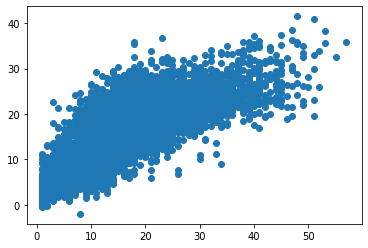

In [ ]:
plt.scatter(ride_counts['RideCount'], ride_counts['Pred_RideCount'])

# Revenue Prediction

In [ ]:
df = uber_df.copy()

In [ ]:
def haversine_distance(row):
    """
    Calculate the great circle distance between two points
    on the Earth (specified in decimal degrees)
    """
    # unpack the values from the row
    lat1, lon1, lat2, lon2 = row[['pickup_latitude', 'pickup_longitude',
                                  'dropoff_latitude', 'dropoff_longitude']]
    
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3959 for miles
    return c * r

# Apply the function to the DataFrame and assign the result to a new column
df['distance'] = df.apply(haversine_distance, axis=1)

In [ ]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']).dt.tz_convert(pytz.timezone('US/Eastern'))
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year

In [ ]:
# Replace null values with median integer for passenger_count, hour, day, and month
df['passenger_count'] = df['passenger_count'].fillna(df['passenger_count'].median())
df['hour'] = df['hour'].fillna(df['hour'].median())
df['day'] = df['day'].fillna(df['day'].median())
df['month'] = df['month'].fillna(df['month'].median())
df['year'] = df['year'].fillna(df['year'].median())

# Replace null values with the mean for distance
df['distance'] = df['distance'].fillna(df['distance'].mean())

In [ ]:
X = df[['passenger_count', 'hour', 'day', 'month', 'distance', 'year']]
y = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear Regression R-squared: 0.0012
Decision Tree R-squared: 0.3656
Random Forest R-squared: 0.6440
XGBoost R-squared: 0.6759


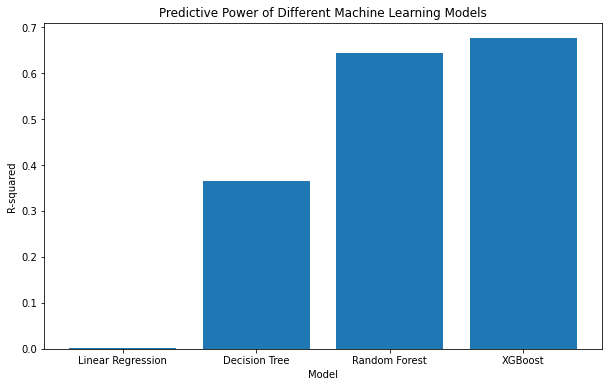

In [ ]:

# Separate the features and target variable
X = df[['passenger_count', 'hour', 'day', 'month', 'distance']]
y = df['fare_amount']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the models
models = {'Linear Regression': LinearRegression(),
          'Decision Tree': DecisionTreeRegressor(random_state=42),
          'Random Forest': RandomForestRegressor(random_state=42),
          'XGBoost': XGBRegressor(random_state=42)}

for name, revenue_model in models.items():
    revenue_model.fit(X_train, y_train)
    y_pred = revenue_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} R-squared: {r2:.4f}")

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(models.keys(), [r2_score(y_test, model.predict(X_test)) for model in models.values()])
ax.set_xlabel('Model')
ax.set_ylabel('R-squared')
ax.set_title('Predictive Power of Different Machine Learning Models')
plt.show()

In [ ]:
# Train the XGBoost model
fare_model = xgb.XGBRegressor(random_state=42)
fare_model.fit(X_train, y_train)

# Save the XGBoost model to disk
fare_model.save_model('xgb_model.bin')

# Create a function that uses the saved model to predict fare amount
def predict_fare_amount(passenger_count, hour, day_of_week, month, distance):
    # Load the trained model from disk
    fare_model = xgb.Booster()
    fare_model.load_model('xgb_model.bin')

    # Prepare the input data as a Pandas DataFrame
    data = {'passenger_count': [passenger_count],
            'hour': [hour],
            'day_of_week': [day_of_week],
            'month': [month],
            'distance': [distance]}
    df = pd.DataFrame(data)

    # Use the trained model to make a prediction
    prediction = fare_model.predict(xgb.DMatrix(df))[0]

    # Return the predicted fare amount
    return prediction

In [ ]:
def ride_rev_model(passenger_count, hour, day, month, distance):
  fare = predict_fare_amount(passenger_count, hour, day, month, distance)
  exp_rev = .85*fare #Uber takes 25%, expected 10% tip
  exp_cost = exp_driver_cost(distance)
  exp_profit = exp_rev - exp_cost

In [ ]:
predict_fare_amount(1,12,3,1,3)

10.84192

# Combining Functions

In [ ]:
predict_fare_amount(1,12,1,1,3)
#passenger count
#hour
#day of week
#month
#distance

10.397377

In [ ]:
predict_ride_count(5,4,12,20)
#hourgroup 0: 0-3, 1: 4-7, etc.
#day of week 0: Su, 1: M, etc.
#month
#day (in month)

24.412382

In [ ]:
def plot_matrix(week_dates_str):
  days = [int(date[:2]) for date in week_dates_str]
  months = [int(date[3:5]) for date in week_dates_str]

  ride_count_matrix = []

  for i in range(6):
      row = []
      for j in range(7):
          month = months[i]
          row.append(predict_ride_count(i, j, months[j], days[j]))
      ride_count_matrix.append(row)

  hourgroups = ['0-3', '4-7', '8-11', '12-15', '16-19', '20-23']

  data = ride_count_matrix

  # Convert data to a numpy array
  data = np.array(data)

  # Create a color map
  cmap = plt.cm.get_cmap('RdYlBu_r')

  # Create a figure and axis object
  fig, ax = plt.subplots()

  # Plot the heatmap with color map
  im = ax.imshow(data, cmap=cmap)

  # Add a color bar
  cbar = ax.figure.colorbar(im, ax=ax)

  # Set the tick labels
  ax.set_xticks(np.arange(len(week_dates_str)))
  ax.set_yticks(np.arange(len(hourgroups)))
  ax.set_xticklabels(week_dates_str)
  ax.set_yticklabels(hourgroups)

  # Rotate the tick labels and set their alignment
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

  # Loop over the data and add annotations to the heatmap
  for i in range(len(hourgroups)):
      for j in range(len(week_dates_str)):
          text = ax.text(j, i, "{:.1f}".format(data[i, j]),
                        ha="center", va="center", color="w")

  # Set the title
  ax.set_title("Ride Count Heatmap")

  # Show the plot
  plt.show()

In [ ]:
from datetime import datetime, timedelta

# Get user input for day, month, and year
day = int(input("Please enter the day (1-31): "))
month = int(input("Please enter the month (1-12): "))
year = int(input("Please enter the year (e.g., 2023): "))

# Create a datetime object for the input date
input_date = datetime(year, month, day)

# Find the Sunday of the given week
days_to_subtract = (input_date.weekday() + 1) % 7  # Sunday is 0, Saturday is 6
sunday = input_date - timedelta(days=days_to_subtract)

# Create a list of dates from Sunday through Saturday
week_dates = [sunday + timedelta(days=i) for i in range(7)]

# Format the dates as strings with the desired format
week_info = [date.strftime("%d-%m-%Y") for date in week_dates]

print("The week's dates are:")
print(week_info)


Please enter the day (1-31): 25
Please enter the month (1-12): 12
Please enter the year (e.g., 2023): 2019
The week's dates are:
['22-12-2019', '23-12-2019', '24-12-2019', '25-12-2019', '26-12-2019', '27-12-2019', '28-12-2019']


<ipython-input-27-a9a2b83356ad>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu_r')


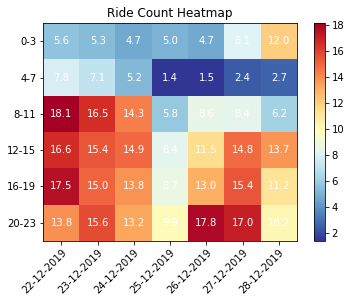

In [ ]:
plot_matrix(week_info)

[[4.9779134, 5.646223, 7.794437, 6.2530346, 10.402869, 19.915485, 27.55209],
 [8.843892, 8.525995, 8.251875, 6.970343, 8.622312, 6.5286446, 6.486949],
 [18.765026, 19.868185, 19.399042, 18.747896, 19.726233, 15.613943, 14.621603],
 [24.700785, 19.541405, 18.459448, 17.966957, 21.607067, 20.672026, 19.006367],
 [26.653685, 21.37152, 20.48902, 20.416208, 24.90384, 23.31069, 19.041077],
 [23.232323, 22.520916, 22.731163, 25.388206, 26.586246, 27.58884, 17.499279]]